# Relations from occurrences in the same sentences

In [2]:
collab = False

def read_file(file_name):
    with open(file_name,'r+', encoding="utf-8") as f:
        lines = f.readlines()
          
    return lines


if not collab: path = './data/book_text'
else: 
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/book_text.txt'

text = read_file(path)

# remove all the \n in the text
text = [x.strip() for x in text]
text = ' '.join(text)

import nltk
nltk.download("punkt")
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
sentences = tokenizer.tokenize(text)

text[:100]

[nltk_data] Downloading package punkt to /home/louis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'PART ONE     CHAPTER I A SHIFTING REEF   The year 1866 was signalised by a remarkable incident, a my'

In [3]:
import pickle
import re
# print the named entities frist 10
def load_nes(type):
    
    with open('./data/named_entities.pickle', 'rb') as f:
        i = 0

        nes_raw = [];
        while True:
            try:
                ne = pickle.load(f)
                # print all the GPE entities, GPE: Geopolitical Entity
                if ne.label() == type :nes_raw.append(str(ne))

            except EOFError:
                break
    return process_nes(nes_raw,type)

def process_nes(nes,type):
    transformed_nes = []
    i=0
    for ne in nes:
        loc = ne.replace('('+type+' ','')
        loc = re.sub(r'/[A-Z]+','',loc)
        loc = loc.replace(')','')
        if i<10: print(loc)
        i+=1
        transformed_nes.append(loc)

    transformed_nes = list(set(transformed_nes))
    
    return transformed_nes

In [4]:
locations = load_nes('LOCATION')
persons = load_nes('PERSON')

West India
North Pacific Ocean
North Sea
North Pacific Ocean
East River
North
Northern Pacific
France
North Sea
Southern Seas
_Governor Higginson_
Burnach Steam Navigation Company
Baker
Pacific Steam Navigation Company
_Helvetia_
_Pereire_
Dick
Pliny
Bishop Pontoppidan
Paul Heggede


In [30]:
import numpy as np
# sort entities by document frequency
from collections import Counter
def sort_by_df(entities):
    c = Counter(entities)
    return c.most_common()

locations_sorted = sort_by_df(locations)
persons_sorted = sort_by_df(persons)

persons_merged = persons_sorted.copy()
to_delete = []
# entity normalisation by simply merging composed entity with their short version, e.g. Captain Nemo and Nemo
for i in range(len(persons_sorted)):
    if ' ' not in persons_sorted[i][0]:
        ne = persons_sorted[i][0]
        # find if there is a composed entity containing the short entity
        for j in range(len(persons_sorted)):
            psj = persons_sorted[j][0].split(',')
            psj = np.array([x.split(' ') for x in psj]).flatten()

            if any(ne ==x for x in psj) and ' ' in persons_sorted[j][0]:
                persons_merged[j] = (persons_merged[j][0]+', '+ne,persons_merged[j][1]+persons_sorted[i][1])

                print(persons_merged[j], i)
                to_delete.append(i)


('Vigo Bay, Vigo', 2) 9
('Captain Farragut, Farragut', 2) 31
('Happy Ned, Ned', 2) 37
('Poor Ned, Ned', 2) 37
('Master Ned, Ned', 2) 37
('Friend Ned, Ned', 2) 37
('Mr. Ned Land, Ned', 2) 37
('Ned Land, Ned', 2) 37
('Sir Naturalist, Sir', 2) 38
('La Boussole, La', 2) 47
('La Perouse, La', 2) 47
('Master Conseil, Conseil', 2) 62
('Manaar Island, Island', 2) 63
('Keeling Island, Island', 2) 63
('George Island, Island', 2) 63
('Captain Anderson, Anderson', 2) 67
('Port Said, Port', 2) 98
('Vigo Bay, Vigo, Bay', 3) 136
('Mr. Ned Land, Ned, Land', 3) 139
('Ned Land, Ned, Land', 3) 139
('Master Land, Land', 2) 139
('Mr. Land, Land', 2) 139
('Mr. Harrington, Mr.', 2) 157
('Mr. Darwin, Mr.', 2) 157
('Mr. Ned Land, Ned, Land, Mr.', 4) 157
('Mr. Aronnax, Mr.', 2) 157
('Mr. Land, Land, Mr.', 3) 157
('Mr. Naturalist, Mr.', 2) 157
('Professor Aronnax, Professor', 2) 170
('Arabia Petraea, Arabia', 2) 186
('Master Ned, Ned, Master', 3) 222
('Master Conseil, Conseil, Master', 3) 222
('Master Land, Land

In [31]:
# delete the short entities at once
persons_merged = [i for j, i in enumerate(persons_merged) if j not in to_delete]

other_captains = ['Captain Anderson, Anderson, Captain','Captain Farragut, Farragut, Captain','Captain Crespo, Captain','Captain Bell, Captain','Captain Fitzroy, Captain','Captain Denham, Captain','Captain Paul Bos, Captain', 'Captain Anderson, Captain, Anderson', 'Captain Farragut, Captain, Farragut']
for i,p in enumerate(persons_merged):
    if any(p[0] == x for x in other_captains):
        
        persons_merged[i] = (persons_merged[i][0].replace(', Captain',''),persons_merged[i][1])
        print('del',persons_merged[i])

print('----------------')

# sort the persons_merged by document frequency
persons_merged = sorted(persons_merged, key=lambda x: x[1], reverse=True)


del ('Captain Paul Bos', 2)
del ('Captain Denham', 2)
del ('Captain Fitzroy', 2)
del ('Captain Farragut, Farragut', 3)
del ('Captain Crespo', 2)
del ('Captain Anderson, Anderson', 3)
del ('Captain Bell', 2)
----------------


In [32]:
for i in range(len(persons_merged)):    print(persons_merged[i])

('Mr. Ned Land, Ned, Land, Mr.', 4)
('Master Ned, Ned, Master', 3)
('Mr. Darwin, Mr., Darwin', 3)
('Captain Farragut, Farragut', 3)
('Captain Anderson, Anderson', 3)
('La Boussole, La, Boussole', 3)
('Master Conseil, Conseil, Master', 3)
('Captain Nemo, Nemo, Captain', 3)
('Ned Land, Ned, Land', 3)
('Vigo Bay, Vigo, Bay', 3)
('Master Land, Land, Master', 3)
('Mr. Land, Land, Mr.', 3)
('Port Said, Port', 2)
('Happy Ned, Ned', 2)
('Poor Ned, Ned', 2)
('Mr. Harrington, Mr.', 2)
('Sandy Hook Point, Point', 2)
('Captain Paul Bos', 2)
('Arabia Petraea, Arabia', 2)
('Sir Naturalist, Sir', 2)
('Louis XIV, Louis', 2)
('Arabian Tunnel, Arabian', 2)
('Manaar Island, Island', 2)
('Arabian Edrisi, Arabian', 2)
('Friend Ned, Ned', 2)
('Captain Denham', 2)
('Captain Fitzroy', 2)
('Louis Philippe, Louis', 2)
('Captain Crespo', 2)
('Professor Aronnax, Professor', 2)
('Captain Bell', 2)
('Keeling Island, Island', 2)
('Louis XVI, Louis', 2)
('Mr. Aronnax, Mr.', 2)
('George Island, Island', 2)
('Mr. Natur

In [33]:
# count the number of matches for each PERSON entity and LOCATION entity
def count_matches(entities, sentences):
    # count the number of sentences that containing all the entities
    count = 0
    for sentence in sentences:
        match = True
        for entity in entities:
            
            variations = entity.split(', ')
            if not any(variation in sentence for variation in variations):
                match = False
                break

        if match: count += 1
    return count


def sentence_match(sentences, entities_class1, entities_class2):
    # set of all the person-location combinations
    person_location_pairs = [[person, location] for person in entities_class1 for location in entities_class2]
    # remove duplicate pairs
    person_location_pairs = list(set(tuple(sorted(l)) for l in person_location_pairs))

    # count the number of matches for each person-location pair
    person_location_pairs_count = []
    for pair in person_location_pairs:
        count = count_matches(pair, sentences)
        person_location_pairs_count.append([pair[0], pair[1], count])

    # sort the pairs by the number of matches
    person_location_pairs_count = sorted(person_location_pairs_count, key=lambda x: x[2], reverse=True)
    return person_location_pairs_count


In [ ]:

person_location_pairs_count = sentence_match(sentences, persons, locations)
# remove the counts from the persons_merged
persons_merged_str = [x[:-1][0] for x in persons_merged]
person_location_pairs_count_merged = sentence_match(sentences, persons_merged_str, locations)
# print the top 10 pairs
for i in range(10):    print(person_location_pairs_count[i])


In [10]:
# display the graph
import networkx as nx                                                             
import matplotlib.pyplot as plt                                                   
import numpy as np
# plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')

def display_graph(person_location_pairs_count, persons, locations, name):

        fig = plt.figure(num=None, figsize=(10, 10))
        G = nx.DiGraph()                                                                  
                                                                                        
        # add the edges to the graph
        for pair in person_location_pairs_count:
                if pair[2] > 1: 
                        # e1 = pair[0].split(',')[0]
                        # e2 = pair[1].split(',')[0]
                        G.add_edge(pair[0], pair[1], weight=pair[2], label=pair[2])

        pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))    

        # dictionary of node degrees
        d = dict(nx.degree(G))
        # colors based on node type, PERSON: red, LOCATION: blue
        colors = ['lightblue' if node in locations else 'red' for node in G.nodes()]

        # labels = nx.get_edge_attributes(G, 'weight')

        nx.draw(G, pos, node_color=colors, 
                with_labels=True, 
                nodelist=list(d.keys()), 
                node_size=[d[k]*200 for k in d])    
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
                                                                            
        plt.show()

        # save the graph
        nx.write_gexf(G, "./plots/"+name+"graph.gexf")


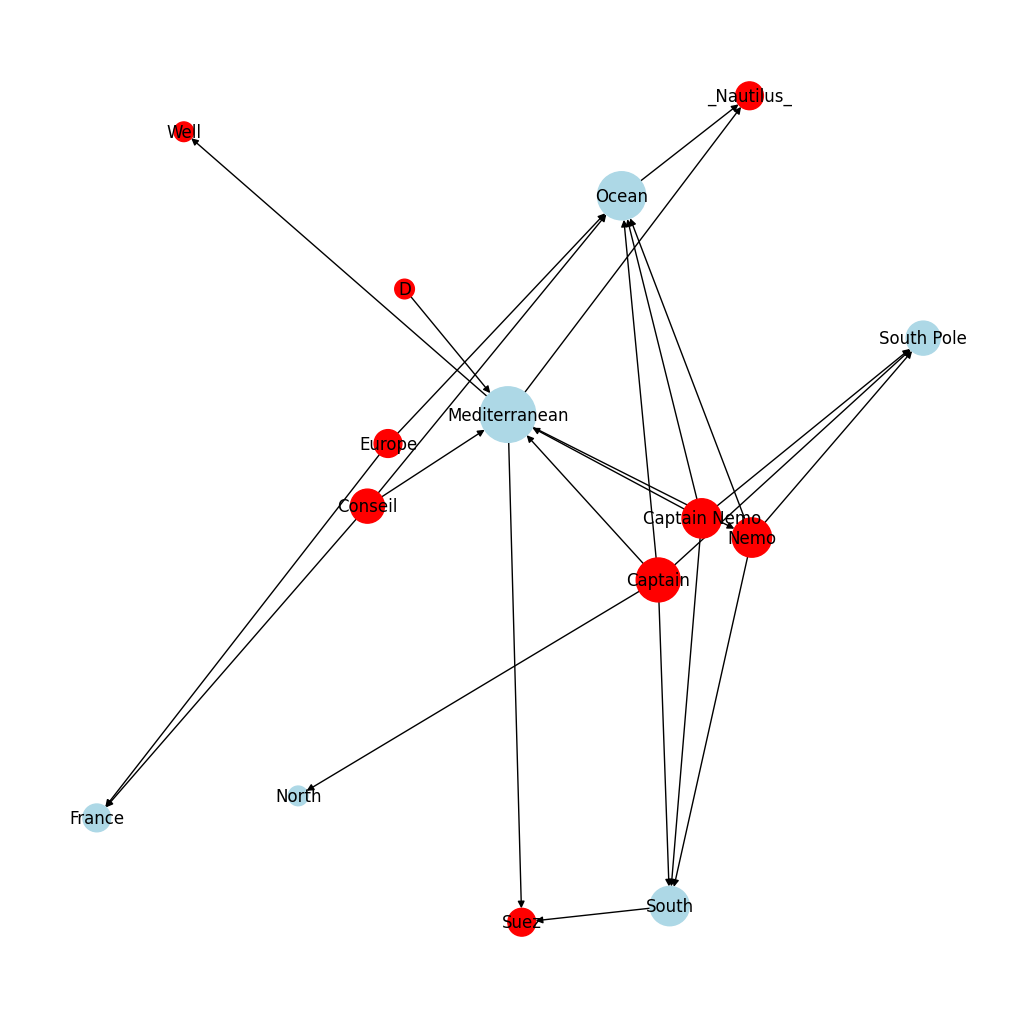

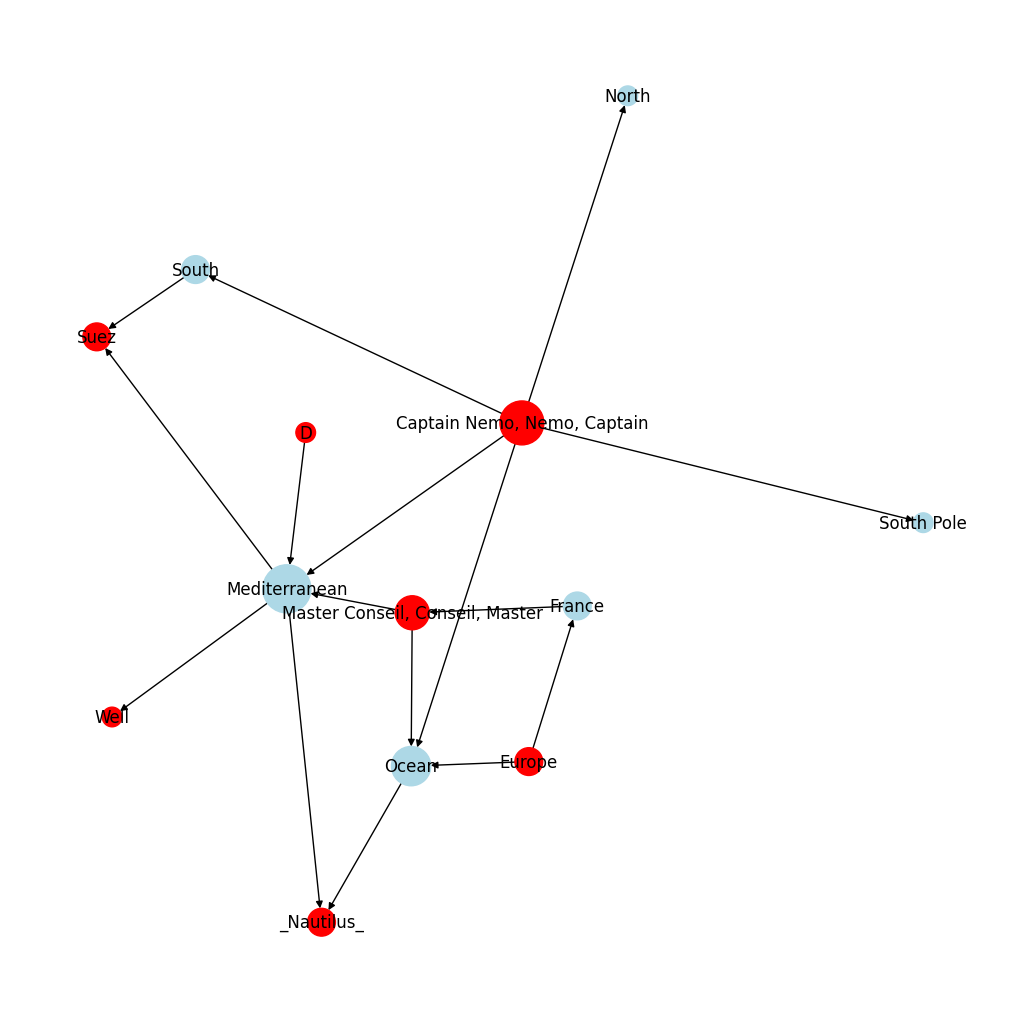

In [ ]:

display_graph(person_location_pairs_count, persons, locations, 'original_')
display_graph(person_location_pairs_count_merged, persons_merged_str, locations, 'merged_')

In [ ]:
# extract nautical coordinates
import pandas as pd
df_coo  = pd.read_csv('./data/coordinates.csv')
df_coo.head()

coos_tokens = []
for coo in df_coo['index']:   coos_tokens.append(text[coo-15:coo])

coos_tokens[:10]

person_location_pairs_count = sentence_match(sentences, persons, coos_tokens)
# print the top 10 pairs
for i in range(10):    print(person_location_pairs_count[i])

['Cape Wessel', 'ituation in 135', 1]
['Captain', 'hat name in 122', 1]
['Dillon', 'land situated 8', 1]
['Captain', 'here, and in 32', 1]
['Vasco', 'ated between 10', 1]
['Captain', 'situation at 51', 1]
['Vasco', 'ween 10° and 14', 1]
['Nemo', 'hat name in 122', 1]
[' evening, in 21', 'Arabia', 1]
['D', 'land situated 8', 1]


# Coreference resolution

## Using NeuralCoref to resolve the coreference

In [ ]:
# alternative: coreferee, https://github.com/richardpaulhudson/coreferee
# !pip uninstall spacy 
# !pip install spacy==2.9.3
# !pip install neuralcoref
# !python3 -m spacy download en_core_web_sm

# import neuralcoref
# help(neuralcoref)

# import types
# import yourmodule

# print([getattr(yourmodule, a) for a in dir(yourmodule)
#   if isinstance(getattr(yourmodule, a), types.FunctionType)])

# import spacy
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# en-core-web-lg 2.3.1 requires spacy<2.4.0,>=2.3.0, but you have spacy 3.5.3 which is incompatible.
# mordecai 2.1.0 requires spacy<3.0,>=2.3, but you have spacy 3.5.3 which is incompatible
# nlp = spacy.load("en_core_web_sm")
# doc = nlp('Barack Obama was born in Hawaii.  He was elected president in 2008.')
# for token in doc:
#     print(token.text,  token.pos_,  token.dep_)

# solve co-reference resolution by assigning the nearest noun as the subject   

In [ ]:

# Load your usual SpaCy model (one of SpaCy English models)
import spacy
nlp = spacy.load('en_core_web_sm')

# Add neural coref to SpaCy's pipe
import neuralcoref
neuralcoref.add_to_pipe(nlp)

# You're done. You can now use NeuralCoref as you usually manipulate a SpaCy document annotations.
doc = nlp(u'My sister has a dog. She loves him.')

doc._.has_coref
doc._.coref_clusters

[My sister: [My sister, She], a dog: [a dog, him]]

In [ ]:
# https://kaustavmukherjee-66179.medium.com/installing-neuralcoref-properly-and-testing-out-with-an-example-5f7e049570ef
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
import nltk

nlp = spacy.load('en_core_web_sm')
# nlp = spacy.load('en')
import neuralcoref
coref = neuralcoref.NeuralCoref(nlp.vocab)
#nlp = spacy.load('en')
nlp.add_pipe(coref, name='neuralcoref')
# You're done. You can now use NeuralCoref the same way you usually manipulate
#  a SpaCy document and it's annotations.

def read_file(file_name):
    with open(file_name) as f:
        lines = f.readlines()
    return lines

path = './data/book_text'

text = read_file(path)

# remove all the \n in the text
text = [x.strip() for x in text]
text = ' '.join(text)
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
sentences = tokenizer.tokenize(text)
# sentences[:10]

In [ ]:
import tqdm
#  coreference resolution
coref_text =''
window_size = 4
for i in tqdm.tqdm(range(len(sentences))):
    i=i+1
    sub_text=''
    
    #  handling edge cases
    if i < window_size:     sub_text = sentences[:i]
    else:      sub_text = sentences[i-window_size:i]
       
    sub_text = ' '.join(sub_text)
    
    doc = nlp(sub_text)
    if doc._.has_coref:
        # print(doc._.coref_clusters)
        # print(doc._.coref_resolved)
        corefed_text = doc._.coref_resolved
        sentences_corefed = tokenizer.tokenize(corefed_text)
    else:   
        sentences_corefed = tokenizer.tokenize(sub_text)

    sentence_corefed = sentences_corefed[-1]

    coref_text += " "+sentence_corefed

# save the corefed text
with open('./data/corefed_text.txt', 'w') as f:
    f.write(coref_text)


100%|██████████| 5396/5396 [04:37<00:00, 19.44it/s]


## Coreference resolution using FastCoref

In [57]:
# run this code in collab or in a GPU machine
# !pip install fastcoref
from fastcoref import FCoref

model = FCoref(device='cuda:0')

text = read_file(path)
text = ' '.join(text)
# split into paragraphs
paragraphs = text.split('\n \n')
paragraphs = [p.strip().replace('\n','') for p in paragraphs if len(p) > 0] # remove empty paragraphs

preds = model.predict(
   texts=paragraphs
)


Map:   0%|          | 0/2402 [00:00<?, ? examples/s]

Inference:   0%|          | 0/2402 [00:00<?, ?it/s]

In [26]:
for i in range(10):
  if preds[i].get_clusters(): 
    print(paragraphs[i])
    print(i, preds[i].get_clusters())
    print(preds[i].get_clusters(as_strings=False))
    print(paragraphs[i][369: 387])
    print()

The year 1866 was signalised by a remarkable incident, a mysterious and puzzling phenomenon, which doubtless no one has yet forgotten. Not to mention rumours which agitated the maritime population and excited the public mind, even in the interior of continents, seafaring men were particularly excited. Merchants, common sailors, captains of vessels, skippers, both of Europe and America, naval officers of all countries, and the Governments of several states on the two continents, were deeply interested in the matter.
3 [['Europe and America', 'the two continents']]
[[(369, 387), (463, 481)]]
Europe and America

The facts relating to this apparition (entered in various log-books) agreed in most respects as to the shape of the object or creature in question, the untiring rapidity of its movements, its surprising power of locomotion, and the peculiar life with which it seemed endowed. If it was a cetacean, it surpassed in size all those hitherto classified in science. Taking into considerat

In [81]:
def resolve_coref(pred,text):                                                  
   cluster_strs = pred.get_clusters()                                           
   cluster_locs = pred.get_clusters(as_strings=False)                           
                                                                                
   index = 0                                                                    
   for i,c in enumerate(cluster_strs):                                          
       for loc in cluster_locs[i]:                                              
         a = text[:index+int(loc[0])]                                           
         b = str(c)                                                             
         cc = text[index+int(loc[1]):]                                          
         index= index + len(b)-(loc[1]-loc[0])                                  
         text = a+b+cc                                                          
                                                                                
   return text                                                                  
                                                                                
parag3 = paragraphs[6]                                                         
print(parag3)                                                                  
resolve_coref(preds[6],parag3)  

On the 20th of July, 1866, the steamer _Governor Higginson_, of the Calcutta and Burnach Steam Navigation Company, had met this moving mass five miles off the east coast of Australia. Captain Baker thought at first that he was in the presence of an unknown sandbank; he even prepared to determine its exact position, when two columns of water, projected by the inexplicable object, shot with a hissing noise a hundred and fifty feet up into the air. Now, unless the sandbank had been submitted to the intermittent eruption of a geyser, the _Governor Higginson_ had to do neither more nor less than with an aquatic mammal, unknown till then, which threw up from its blow-holes columns of water mixed with air and vapour.


"On the 20th of July, 1866, the steamer _Governor Higginson_, of the Calcutta and Burnach Steam Navigation Company, had met this moving mass five miles off the east coast of Australia. ['Captain Baker', 'he', 'he'] thought at first that ['Captain Baker', 'h['the steamer _Governor Higginson_, of the Calcutta and Burnach Steam Navigation Company', 'the _Governor Higginson_']']apt['an unknown sandbank', 'its', 'the sandbank']he'] even prepared to determine ['an unknown sandbank', 'its', 'the sandbank'] exact position, when two columns of water, projected by the inexplicable object, shot with['this moving mass', 'the inexplicable object']red and fifty feet up into the air. Now, unless ['an unknown sandbank', 'its', 'the sandbank'] had been submitted to the intermittent eruption of a geyser, ['the steamer _Governor Higginson_, of the Calcutta and Burnach Steam Navigation Company', 'the _Governor Higginson_'] had to do neither more nor less than with ['an aquatic mammal, unknown till then, w

In [92]:
# rewrite text using coreference resolutions
def reslove_coef(pred,text):
  cluster_strs = pred.get_clusters()
  cluster_locs = pred.get_clusters(as_strings=False)

  clusters = []
  for i,c in enumerate(cluster_strs):
      for loc in cluster_locs[i]:
        clusters.append((c,loc[0],loc[1]))
  clusters.sort(key=lambda x:x[1])                                                 

  index = 0
  for clus in clusters:
    text = list(text)
    a = "".join(text[:index+int(clus[1])])
    b = str(clus[0])
    c = ''.join(text[index+int(clus[2]):])
    index= index + len(b)-(clus[2]-clus[1])
    text = a+b+c
  return ''.join(text)
    


parag3 = paragraphs[6]
print(reslove_coef(preds[6],parag3))

with open('/content/drive/MyDrive/fast_corefed_text.txt', 'w+', encoding="utf-8") as f:
    for i,p in enumerate(paragraphs):
      coref_text = reslove_coef(preds[i],p)
      f.write(coref_text+" \n \n")

On the 20th of July, 1866, ['the steamer _Governor Higginson_, of the Calcutta and Burnach Steam Navigation Company', 'the _Governor Higginson_'], had met ['this moving mass', 'the inexplicable object'] five miles off the east coast of Australia. ['Captain Baker', 'he', 'he'] thought at first that ['Captain Baker', 'he', 'he'] was in the presence of ['an unknown sandbank', 'its', 'the sandbank']; ['Captain Baker', 'he', 'he'] even prepared to determine ['an unknown sandbank', 'its', 'the sandbank'] exact position, when two columns of water, projected by ['this moving mass', 'the inexplicable object'], shot with a hissing noise a hundred and fifty feet up into the air. Now, unless ['an unknown sandbank', 'its', 'the sandbank'] had been submitted to the intermittent eruption of a geyser, ['the steamer _Governor Higginson_, of the Calcutta and Burnach Steam Navigation Company', 'the _Governor Higginson_'] had to do neither more nor less than with ['an aquatic mammal, unknown till then, wh

## Computing the relation pairs using Fast

In [35]:
def read_file(file_name):
    with open(file_name,  'r', encoding="utf-8") as f:
        lines = f.readlines()
    return lines

if collab: path = '/content/drive/MyDrive/fast_corefed_text.txt'
else: path = './data/fast_corefed_text.txt'

coref_text = read_file(path)
coref_text = ''.join(coref_text)
coref_text = ''.join(coref_text)
coref_text = coref_text.replace('\n','')
# print(coref_text[:1000])
import nltk
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

# remove dots after N. S. W. E. lat. and long. unless the dot is followed by a capital letter
for i in range(len(coref_text)):
    try:
        if coref_text[i] == '.':
            sub_text = coref_text[i-5:i+1]
            if  any(x in sub_text for x in ['N.','S.', 'E.','W.', 'lat.', 'long.']):
                if coref_text[i+1].isupper() or coref_text[i+2].isupper(): continue
                else: coref_text = coref_text[:i] + coref_text[i+1:]
    except:
        pass


coref_sentences = tokenizer.tokenize(coref_text)
coref_sentences[0]

'PART ONE    CHAPTER I A SHIFTING REEF  The year 1866 was signalised by a remarkable incident, a mysterious and puzzling phenomenon, which doubtless no one has yet forgotten.'

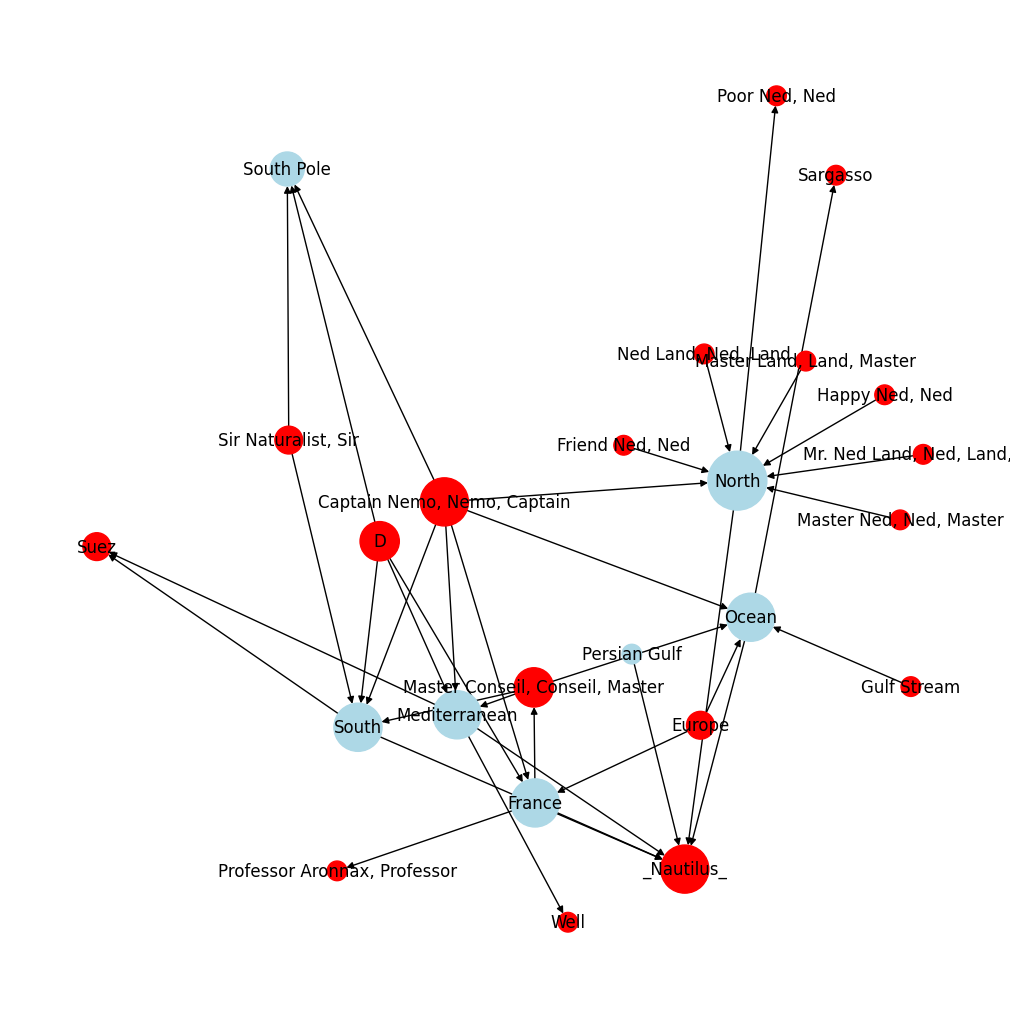

In [46]:
person_location_pairs_count_merged_coref = sentence_match(coref_sentences, persons_merged_str, locations)
display_graph(person_location_pairs_count_merged_coref, persons_merged_str, locations, 'merged_fast_corefed_')

## Computing the relation pairs using NeuralCoref

In [ ]:
def read_file(file_name):
    with open(file_name) as f:
        lines = f.readlines()
    return lines

path = './data/corefed_text.txt'

coref_text = read_file(path)[0]

import nltk
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

# remove dots after N. S. W. E. lat. and long. unless the dot is followed by a capital letter
for i in range(len(coref_text)):
    try:
        if coref_text[i] == '.':
            sub_text = coref_text[i-5:i+1]
            if  any(x in sub_text for x in ['N.','S.', 'E.','W.', 'lat.', 'long.']):
                if coref_text[i+1].isupper() or coref_text[i+2].isupper(): continue
                else: coref_text = coref_text[:i] + coref_text[i+1:]
    except:
        pass


coref_sentences = tokenizer.tokenize(coref_text)
coref_sentences[0]

' PART ONE     CHAPTER I A SHIFTING REEF   The year 1866 was signalised by a remarkable incident, a mysterious and puzzling phenomenon, which doubtless no one has yet forgotten.'

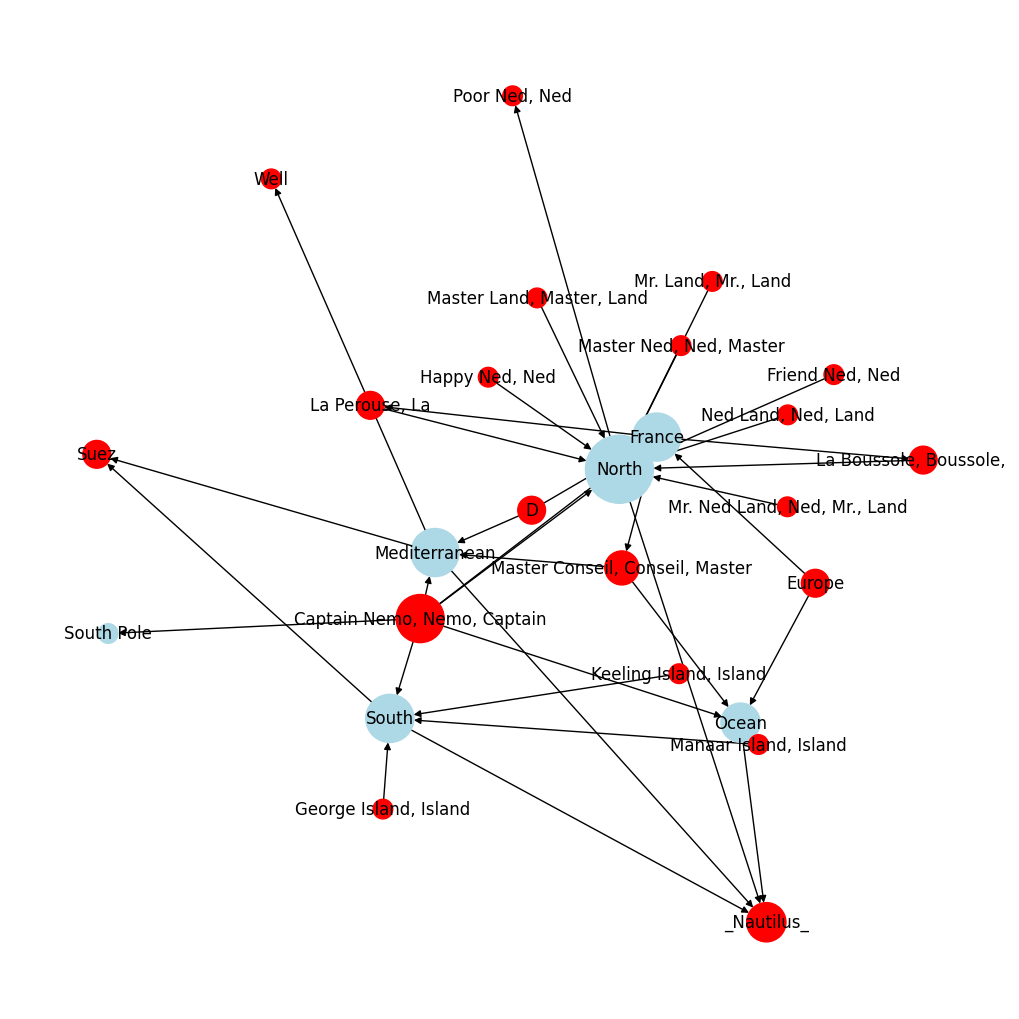

In [ ]:

person_location_pairs_count_merged_coref = sentence_match(coref_sentences, persons_merged_str, locations)
display_graph(person_location_pairs_count_merged_coref, persons_merged_str, locations, 'merged_corefed_')

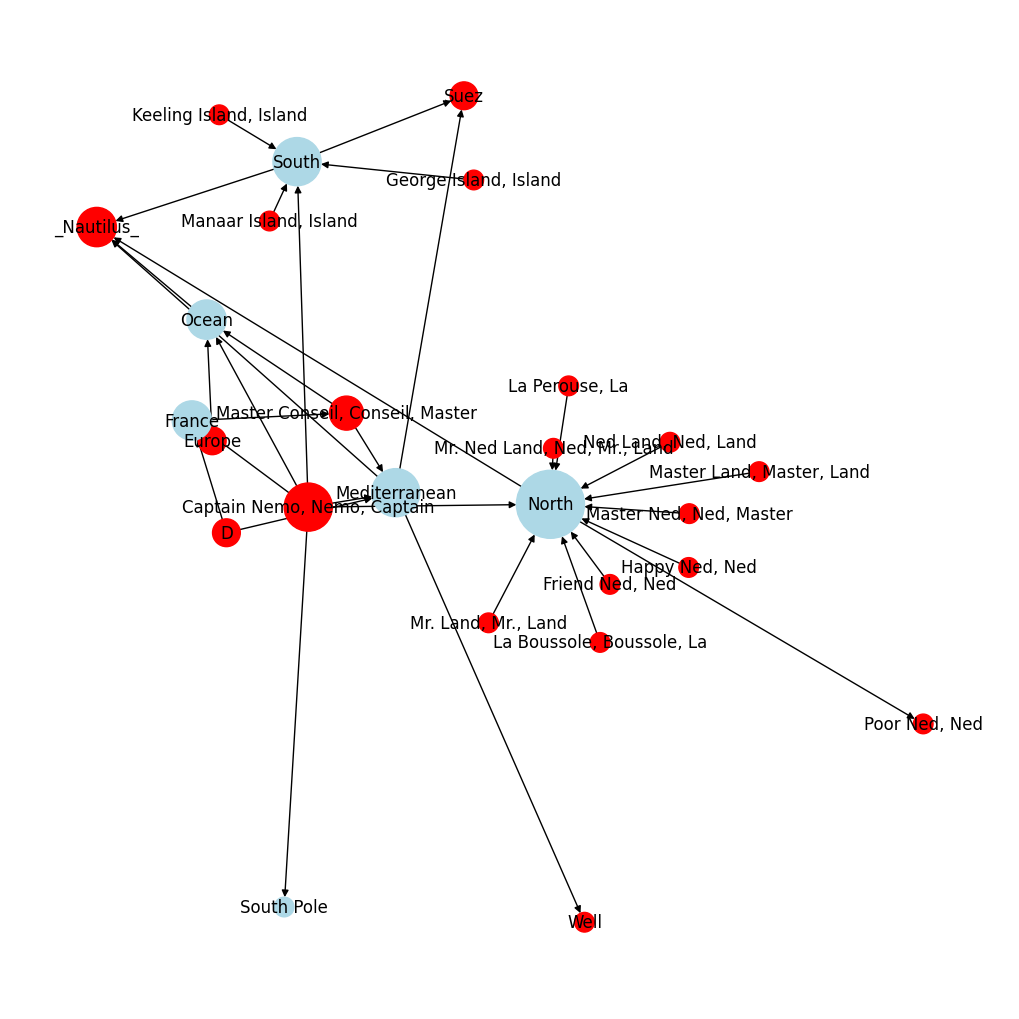

In [ ]:

display_graph(person_location_pairs_count_merged_coref, persons_merged_str, locations, 'merged_corefed_')

# LLM for filtering NER
 for a NER - is this a LOCATION, based on context?

In [ ]:
# from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig    
# import torch                                                                      
# from peft import PeftModel
# # https://huggingface.co/spaces/tloen/alpaca-lora
# tokenizer = LlamaTokenizer.from_pretrained("decapoda-research/llama-7b-hf") 
# model = LlamaForCausalLM.from_pretrained("decapoda-research/llama-7b-hf")      
# # state_dict=torch.load('./adapter_model/data.pkl')

# LORA_WEIGHTS = "tloen/alpaca-lora-7b"

# config = GenerationConfig(max_length=50)                                       
# device = "cpu"

# model = PeftModel.from_pretrained(
#         model,
#         LORA_WEIGHTS,
#         device_map={"": device},
#     )    

                                                                        
# input_text = "This is a test sentence."                                        
# input_ids = tokenizer.encode(input_text, return_tensors='pt')                  
# output_ids = model.generate(input_ids=input_ids, config=config)                
# output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)        
                                                                            
# print(output_text)

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM     

llm_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")               
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

/home/louis/anaconda3/envs/textmining/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import tqdm as tqdm
gpes = load_nes('GPE')
gpes = list(set(gpes))
gpe_sentences = []

for sentence in tqdm.tqdm(coref_sentences):
    contained_gpe = [gpe for gpe in gpes if gpe in sentence]
    if len(contained_gpe) > 0:
        gpe_sentences.append((contained_gpe,sentence))

print(len(gpe_sentences))

for gpe, sentence in gpe_sentences[:20]:
    print(gpe, sentence)

Europe
America
Australia
Captain
Similar
Fifteen
United States
Europe
Aleutian
Kulammak


100%|██████████| 5365/5365 [00:00<00:00, 13545.73it/s]

2586
['No'] Not to mention rumours which agitated the maritime population and excited the public mind, even in the interior of continents, seafaring men were particularly excited.
['Governments', 'America', 'Europe'] Merchants, common sailors, captains of vessels, skippers, both of Europe and America, naval officers of all countries, and the Governments of several states on the two continents, were deeply interested in the matter.
['Calcutta', 'Australia', 'Company'] On the 20th of July, 1866, the steamer _Governor Higginson_, of the Calcutta and Burnach Steam Navigation Company, had met this moving mass five miles off the east coast of Australia.
['Captain'] Captain Baker thought at first that Captain Baker was in the presence of an unknown sandbank; Captain Baker even prepared to determine he was in the presence of an unknown sandbank exact position, when two columns of water, projected by the inexplicable object, shot with a hissing noise a hundred and fifty feet up into the air.
['

In [ ]:
question = 'Are the protagonists talking about where they were?'
test2 = 'Our course was directed to the west, and on the 11th of January we doubled Cape Wessel, situation in 135° long. and 10° S.'
test1 = "Will the missing vessel tell us by the missing vessel nationality that of Captain Nemo?"

def run_t5(question, sentence):
    input_ids = llm_tokenizer.encode(question+" "+sentence, return_tensors="pt") 

    output_ids = model.generate(input_ids)                                         
    output_text = llm_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text

print(run_t5(question, test1))
print(run_t5(question, test2))

def llm_filter(question, sentences):
    location_sentences = []
    for sent in tqdm.tqdm(sentences):
        
        if len(sent)==2: sent_text =sent[1]
        else: sent_text = sent 
        output_text = run_t5(question, sent_text).lower()

        if output_text == 'yes':
            location_sentences.append(sent)
        else:
            if output_text != 'no':
                print(output_text)
            # print(output_text)
            pass
    return location_sentences

no
yes


In [ ]:

location_gpe_sentences = llm_filter(question, gpe_sentences)

print(len(location_gpe_sentences))
for gpe, sentence in location_gpe_sentences[:10]:
    print(gpe, sentence)

# save the location sentences
with open('./data/gpe_location_sentences.txt', 'w') as f:
    for gpe, sentence in location_gpe_sentences:
        f.write(gpe[0]+' | '+sentence+'\n')

  1%|          | 19/2586 [00:06<15:04,  2.84it/s]

captain anderson hastened to reassure the passengers.


  2%|▏         | 50/2586 [00:14<11:57,  3.53it/s]

j.


  2%|▏         | 63/2586 [00:18<24:21,  1.73it/s]

i said, “i am not going to be able to make preparations for my departure


  3%|▎         | 69/2586 [00:20<16:29,  2.54it/s]

no, he was not.


  5%|▍         | 126/2586 [00:36<15:13,  2.69it/s]

97,500 lbs.


  5%|▍         | 127/2586 [00:36<16:24,  2.50it/s]

320 feet


  5%|▍         | 129/2586 [00:38<23:09,  1.77it/s]

the canadian was a canadian citizen.


  5%|▌         | 141/2586 [00:42<27:08,  1.50it/s]

i looked and looked, till i was nearly blind, whilst conseil, always p


  6%|▋         | 165/2586 [00:49<24:18,  1.66it/s]

“it is a pity that the babiroussa is not in


  6%|▋         | 168/2586 [00:51<18:58,  2.12it/s]

“look out there!


  7%|▋         | 175/2586 [00:53<22:42,  1.77it/s]

what is the captain’s opinion of the narwhal?


  7%|▋         | 188/2586 [00:57<14:53,  2.68it/s]

the protagonists are talking about their lives.


  7%|▋         | 190/2586 [00:58<16:57,  2.35it/s]

” we shall catch the animal!”


  8%|▊         | 203/2586 [01:02<14:41,  2.70it/s]

conseil was a calm person.


  8%|▊         | 212/2586 [01:05<20:33,  1.93it/s]

conseil could articulate some words, and i heard him repeat at intervals, “help!


  8%|▊         | 214/2586 [01:05<19:44,  2.00it/s]

a scream


  8%|▊         | 217/2586 [01:06<15:04,  2.62it/s]

i saw


  9%|▉         | 230/2586 [01:10<16:41,  2.35it/s]

he was a snob.


 11%|█         | 273/2586 [01:21<11:36,  3.32it/s]

i shall sleep well,” said conseil.


 11%|█         | 280/2586 [01:23<11:55,  3.22it/s]

i’m not sure.


 11%|█         | 282/2586 [01:24<25:39,  1.50it/s]

“i have no idea what o’clock it is, unless it is dinner-


 12%|█▏        | 301/2586 [01:31<26:05,  1.46it/s]

abraham lincoln, i am afraid that you are not going to be able to find me.”


 12%|█▏        | 302/2586 [01:32<35:45,  1.06it/s]

no, the submarine was not a monster.


 12%|█▏        | 305/2586 [01:34<29:31,  1.29it/s]

“i am not what you call a civilised man!”


 12%|█▏        | 315/2586 [01:38<21:50,  1.73it/s]

the unknown is a savage.


 13%|█▎        | 340/2586 [01:45<18:39,  2.01it/s]

captain nemo suddenly became silent in the midst of this enthusiasm, by which captain ne


 13%|█▎        | 349/2586 [01:48<10:56,  3.41it/s]

twelve thousand.


 14%|█▎        | 352/2586 [01:49<12:59,  2.86it/s]

i was a librarian.


 15%|█▌        | 389/2586 [02:02<19:45,  1.85it/s]

is this the first time you have mentioned the use of the instrument?


 15%|█▌        | 390/2586 [02:04<30:41,  1.19it/s]

the agent is a powerful agent, obedient, rapid, easy, which conform


 15%|█▌        | 393/2586 [02:06<30:52,  1.18it/s]

i owe all to the ocean; the ocean produces electricity, and electricity gives heat,


 16%|█▌        | 410/2586 [02:11<10:54,  3.32it/s]

by orders.


 16%|█▌        | 411/2586 [02:12<22:08,  1.64it/s]

what is the name of the person who telegraphs to an electric thread?


 16%|█▌        | 418/2586 [02:14<12:59,  2.78it/s]

no, professor.


 16%|█▌        | 419/2586 [02:16<23:43,  1.52it/s]

a moment after we were seated on a divan in the saloon smoking


 16%|█▋        | 426/2586 [02:18<16:18,  2.21it/s]

one-tenth is out of the water.


 17%|█▋        | 441/2586 [02:23<21:36,  1.65it/s]

i ship the screw, and the pressure of the water causes the nautilus to rise vertical


 17%|█▋        | 449/2586 [02:26<14:13,  2.50it/s]

i am not sure.


 17%|█▋        | 452/2586 [02:27<16:28,  2.16it/s]

i am not sure where i am going.


 18%|█▊        | 463/2586 [02:31<13:45,  2.57it/s]

i was not sure what to do.


 19%|█▊        | 483/2586 [02:36<09:29,  3.69it/s]

he was


 19%|█▉        | 502/2586 [02:41<12:01,  2.89it/s]

a tao


 21%|██        | 542/2586 [02:52<12:19,  2.76it/s]

terra firma


 21%|██        | 543/2586 [02:53<17:23,  1.96it/s]

be a secluded place


 21%|██        | 545/2586 [02:54<23:13,  1.46it/s]

what is the island of crespo?


 22%|██▏       | 558/2586 [02:59<17:12,  1.96it/s]

is the apparatus a sailor?


 22%|██▏       | 562/2586 [03:01<16:57,  1.99it/s]

then it is an air-gun.


 25%|██▌       | 649/2586 [03:24<10:12,  3.16it/s]

the sun is shining.


 25%|██▌       | 652/2586 [03:25<10:50,  2.97it/s]

captain nemo


 29%|██▉       | 755/2586 [03:49<09:31,  3.21it/s]

no, they are talking about their home.


 29%|██▉       | 758/2586 [03:50<10:21,  2.94it/s]

i don’t know.


 32%|███▏      | 820/2586 [04:08<11:44,  2.51it/s]

ned land was a snob.


 32%|███▏      | 830/2586 [04:11<15:42,  1.86it/s]

“i do not taste a little of this bread-fruit pie won’t take long


 32%|███▏      | 833/2586 [04:12<11:04,  2.64it/s]

ned.


 33%|███▎      | 860/2586 [04:19<12:20,  2.33it/s]

yes, the birds are alive.


 34%|███▍      | 892/2586 [04:29<12:48,  2.20it/s]

the bipeds were a savage.


 35%|███▍      | 894/2586 [04:31<20:58,  1.34it/s]

captain, i’m sorry, i’m sorry, i’m sorry, i’


 36%|███▌      | 921/2586 [04:39<08:12,  3.38it/s]

conseil!


 36%|███▌      | 937/2586 [04:44<11:08,  2.47it/s]

a.


 37%|███▋      | 953/2586 [04:49<14:58,  1.82it/s]

i have but one thing to say to you: have confidence in the captain, and go to


 37%|███▋      | 962/2586 [04:52<15:18,  1.77it/s]

papuanism is a myth, and the papuans are not.


 37%|███▋      | 963/2586 [04:53<18:27,  1.47it/s]

he was a sailor.


 40%|███▉      | 1034/2586 [05:14<09:41,  2.67it/s]

hallo!


 40%|████      | 1037/2586 [05:17<23:23,  1.10it/s]

ned land is a harpooner.


 44%|████▍     | 1142/2586 [05:49<13:03,  1.84it/s]

these insects adhere to one another sometimes for several leagues.”


 44%|████▍     | 1148/2586 [05:51<08:59,  2.67it/s]

captain nemo.


 45%|████▍     | 1152/2586 [05:52<11:25,  2.09it/s]

no, he was talking about the ship.


 45%|████▍     | 1154/2586 [05:54<13:03,  1.83it/s]

no, he was not.


 45%|████▍     | 1156/2586 [05:55<13:27,  1.77it/s]

tiger in the indian jungles


 45%|████▌     | 1167/2586 [06:00<13:03,  1.81it/s]

“it is a question of how to extract pearls.


 45%|████▌     | 1172/2586 [06:02<10:31,  2.24it/s]

yes, i said.


 45%|████▌     | 1173/2586 [06:03<10:05,  2.33it/s]

ned?


 46%|████▌     | 1179/2586 [06:05<10:08,  2.31it/s]

no, i’m not.


 49%|████▉     | 1270/2586 [06:31<10:41,  2.05it/s]

the canadian was a canadian.


 50%|█████     | 1294/2586 [06:38<06:16,  3.43it/s]

i was a little surprised.


 50%|█████     | 1299/2586 [06:40<11:17,  1.90it/s]

“it is true,” i replied.


 50%|█████     | 1304/2586 [06:43<14:43,  1.45it/s]

i think the first one is that the asteroid was named after the greek god aronna


 51%|█████     | 1307/2586 [06:45<14:37,  1.46it/s]

no, sir.


 51%|█████     | 1321/2586 [06:52<19:02,  1.11it/s]

captain, i am surprised at the way you are describing the situation.


 52%|█████▏    | 1332/2586 [06:58<18:20,  1.14it/s]

is this the first time the protagonist has sought for it?


 53%|█████▎    | 1360/2586 [07:08<09:14,  2.21it/s]

i am not sure.


 53%|█████▎    | 1361/2586 [07:10<13:52,  1.47it/s]

ned land was a harpoon.


 54%|█████▍    | 1402/2586 [07:22<05:40,  3.48it/s]

ned


 55%|█████▍    | 1410/2586 [07:25<08:39,  2.26it/s]

the protagonists are talking about their lives.


 55%|█████▍    | 1413/2586 [07:27<12:02,  1.62it/s]

captain nemo was a savage.


 55%|█████▍    | 1415/2586 [07:29<16:50,  1.16it/s]

“it’s a question of where we are going to end up.”


 55%|█████▍    | 1418/2586 [07:31<17:46,  1.09it/s]

france, england, or america, on which flight may be attempted as advantageously as here.”


 55%|█████▍    | 1419/2586 [07:32<19:18,  1.01it/s]

aronnax, “your arguments are rotten at the foundation.


 55%|█████▍    | 1420/2586 [07:34<22:15,  1.15s/it]

ned land’s logic pressed me hard, and i felt ned land beaten


 55%|█████▌    | 1425/2586 [07:36<15:27,  1.25it/s]

“it is a question of the prudence of the author to leave the


 55%|█████▌    | 1427/2586 [07:38<16:08,  1.20it/s]

yes, it would be a favourable opportunity.


 56%|█████▌    | 1445/2586 [07:44<10:50,  1.75it/s]

i turned towards captain nemo, and in an agitated voice exclaimed: “


 60%|█████▉    | 1547/2586 [08:20<06:12,  2.79it/s]

nearer


 61%|██████    | 1570/2586 [08:27<05:45,  2.94it/s]

captain nemo


 62%|██████▏   | 1603/2586 [08:37<06:32,  2.50it/s]

i’m sure you’re right.


 62%|██████▏   | 1607/2586 [08:38<06:33,  2.49it/s]

captain nemo


 64%|██████▍   | 1660/2586 [08:51<04:52,  3.16it/s]

captain nemo


 65%|██████▌   | 1683/2586 [08:58<06:03,  2.48it/s]

is that you, professor?


 65%|██████▌   | 1684/2586 [08:59<06:23,  2.35it/s]

yes, captain.


 65%|██████▌   | 1692/2586 [09:03<10:37,  1.40it/s]

the men are a shambles of a shambles of


 67%|██████▋   | 1741/2586 [09:18<05:39,  2.49it/s]

the captain is a fictional character.


 69%|██████▉   | 1797/2586 [09:35<05:53,  2.23it/s]

ned stamped ned's feet.


 73%|███████▎  | 1877/2586 [09:57<05:53,  2.01it/s]

captain nemo, what do you think of this?”


 73%|███████▎  | 1881/2586 [09:58<04:18,  2.72it/s]

i knew that.


 73%|███████▎  | 1886/2586 [10:00<04:11,  2.79it/s]

i was excited.


 73%|███████▎  | 1895/2586 [10:04<07:26,  1.55it/s]

the _nautilus_ is armed with a powerful spur, and could


 73%|███████▎  | 1896/2586 [10:05<10:45,  1.07it/s]

i think we should not find the sea open at the south pole as well as at the


 74%|███████▍  | 1916/2586 [10:11<04:43,  2.37it/s]

the protagonists are talking about their lives.


 76%|███████▌  | 1971/2586 [10:28<04:49,  2.13it/s]

he was a sailor


 77%|███████▋  | 1992/2586 [10:34<03:31,  2.81it/s]

a black banner


 77%|███████▋  | 1993/2586 [10:34<03:33,  2.78it/s]

”


 78%|███████▊  | 2015/2586 [10:40<02:41,  3.54it/s]

no.


 79%|███████▊  | 2031/2586 [10:44<02:25,  3.82it/s]

conseil.


 79%|███████▊  | 2032/2586 [10:45<02:45,  3.35it/s]

ned.


 79%|███████▊  | 2033/2586 [10:45<03:36,  2.56it/s]

yes, it is superb!


 79%|███████▉  | 2039/2586 [10:48<04:32,  2.01it/s]

conseil clapped his hands over the man.


 80%|████████  | 2070/2586 [10:56<03:31,  2.44it/s]

no, i was talking to a canadian.


 80%|████████  | 2072/2586 [10:58<06:18,  1.36it/s]

i led the captain to the room where the crew of the _nautilus_


 81%|████████  | 2101/2586 [11:07<04:48,  1.68it/s]

aronnax, we must attempt some desperate means, or we shall be sealed up in this


 81%|████████▏ | 2104/2586 [11:09<06:23,  1.26it/s]

“it’s a good thing that you’re not going to be a


 82%|████████▏ | 2113/2586 [11:12<03:28,  2.27it/s]

is that nemo?


 82%|████████▏ | 2121/2586 [11:16<04:38,  1.67it/s]

my brave conseil took my hand and encouraged me, and i heard my brave conseil murmur,


 82%|████████▏ | 2122/2586 [11:17<07:16,  1.06it/s]

if i could only not breathe, so as to leave more air for my master!”


 83%|████████▎ | 2136/2586 [11:22<03:28,  2.16it/s]

the protagonists are talking about their lives.


 83%|████████▎ | 2148/2586 [11:27<03:19,  2.19it/s]

ned land was not speaking.


 86%|████████▌ | 2217/2586 [11:54<02:06,  2.91it/s]

is that ned?


 86%|████████▌ | 2227/2586 [11:57<02:30,  2.39it/s]

ned was not interested in the subject.


 86%|████████▋ | 2232/2586 [12:00<04:31,  1.30it/s]

the crew tried then to haul it on board, but it weight was so considerable that the tight


 86%|████████▋ | 2236/2586 [12:02<03:15,  1.79it/s]

“yes, conseil.”


 87%|████████▋ | 2237/2586 [12:03<04:08,  1.40it/s]

he was a snob


 87%|████████▋ | 2261/2586 [12:11<03:22,  1.61it/s]

 89%|████████▉ | 2311/2586 [12:24<01:22,  3.33it/s]

no, i am not.


 90%|████████▉ | 2318/2586 [12:27<01:52,  2.37it/s]

aronnax


 93%|█████████▎| 2397/2586 [12:48<01:06,  2.85it/s]

it was a sailor


 93%|█████████▎| 2406/2586 [12:51<00:58,  3.07it/s]

captain nemo


 95%|█████████▍| 2451/2586 [13:03<01:12,  1.87it/s]

i went down at the moment another projectile struck the nautilus, and i heard the


 95%|█████████▌| 2460/2586 [13:06<00:57,  2.20it/s]

i am the judge!


 95%|█████████▌| 2461/2586 [13:07<01:41,  1.24it/s]

i cast a last look at the man-of-war, which was putting on


 96%|█████████▌| 2488/2586 [13:16<00:44,  2.19it/s]

what was ned land's response to the threat?


 97%|█████████▋| 2519/2586 [13:25<00:24,  2.70it/s]

i am not sure.


100%|██████████| 2586/2586 [13:42<00:00,  3.14it/s]

306
['Calcutta', 'Australia', 'Company'] On the 20th of July, 1866, the steamer _Governor Higginson_, of the Calcutta and Burnach Steam Navigation Company, had met this moving mass five miles off the east coast of Australia.
['Captain'] Captain Baker thought at first that Captain Baker was in the presence of an unknown sandbank; Captain Baker even prepared to determine he was in the presence of an unknown sandbank exact position, when two columns of water, projected by the inexplicable object, shot with a hissing noise a hundred and fifty feet up into the air.
['March', 'Company', 'Ocean'] On the 5th of March, 1867, the _Moravian_, of the Montreal Ocean Company, finding herself during the night in 27° 30′ lat and 72° 15′ long, struck on herself starboard quarter a rock, marked in no chart for that part of the sea.
['Company'] The 13th of April, 1867, the sea being beautiful, the breeze favourable, the _Scotia_, of the Cunard Company’s line, found herself in 15° 12′ long and 45° 37′ lat

In [ ]:
coo_sentences = []
for sentence in tqdm.tqdm(coref_sentences):
    if '°' in sentence or 'deg.' in sentence:
        coo_sentences.append(sentence)



100%|██████████| 5365/5365 [00:00<00:00, 1209418.52it/s]


In [ ]:
        
print('coo_sentences')
print(len(coo_sentences))
for sentence in coo_sentences: print(sentence)

coo_sentences
46
Fifteen days later, two thousand miles farther off, the _Helvetia_, of the Compagnie-Nationale, and the _Shannon_, of the Royal Mail Steamship Company, sailing to windward in that portion of the Atlantic lying between the United States and Europe, respectively signalled the monster to each other in 42° 15′ N lat and 60° 35′ W long.
On the 5th of March, 1867, the _Moravian_, of the Montreal Ocean Company, finding herself during the night in 27° 30′ lat and 72° 15′ long, struck on herself starboard quarter a rock, marked in no chart for that part of the sea.
The 13th of April, 1867, the sea being beautiful, the breeze favourable, the _Scotia_, of the Cunard Company’s line, found herself in 15° 12′ long and 45° 37′ lat herself was going at the speed of thirteen knots and a half.
The 20th of July, the tropic of Capricorn was cut by 105° of longitude, and the 27th of the same month our crossed the equator on the 110th meridian.
The frigate was then in 31° 15′ north latitude

In [ ]:
location_coo_sentences = llm_filter(question, coo_sentences)
    
# save the location sentences
with open('./data/coo_location_sentences.txt', 'w') as f:
    for sentence in location_coo_sentences:
        f.write(sentence+'\n')

 13%|█▎        | 6/46 [00:03<00:25,  1.54it/s]

what is the island of crespo?


 48%|████▊     | 22/46 [00:08<00:14,  1.69it/s]

is this the first time the protagonist has sought for it?


 65%|██████▌   | 30/46 [00:11<00:05,  2.85it/s]

3° below zero


100%|██████████| 46/46 [00:15<00:00,  2.96it/s]


In [ ]:

print(len(location_coo_sentences))
for sentence in location_coo_sentences[:10]:
    print(sentence)
    

7
The 13th of April, 1867, the sea being beautiful, the breeze favourable, the _Scotia_, of the Cunard Company’s line, found herself in 15° 12′ long and 45° 37′ lat herself was going at the speed of thirteen knots and a half.
The frigate was then in 31° 15′ north latitude and 136° 42′ east longitude.
we were close to Vanikoro, really the one to which Dumont d’Urville gave the name of Isle de la Recherche, and exactly facing the little harbour of Vanou, situated in 16° 4′ S lat, and 164° 32′ E long.
There Dillon learned the results of Dillon inquiries, and found that a certain James Hobbs, second lieutenant of the Union of Calcutta, after landing on an island situated 8° 18′ S lat, and 156° 30′ E long, had seen some iron bars and red stuffs used by the natives of these parts.
Our course was directed to the west, and on the 11th of January Our doubled Cape Wessel, situation in 135° long and 10° S lat, which forms the east point of the Gulf of Carpentaria.
On the 13th of January, Captain 

In [ ]:
# RBF?
# from rdflib import Graph                                                       
                                                                        
# # Create a new graph                                                           
# g = Graph()                                                                    
                                                                        
# # Load the data from a file                                                    
# g.parse("./data/book_text", format="nt")                                     
                                                                        
# # Print the graph                                                              
# # print(g.serialize(format="turtle").decode("utf-8"))